<a href="https://colab.research.google.com/github/Adarsh-Mohan/Predictive-Maintenance-model-for-Wind-Turbines-/blob/main/Final_Success_code_with_predefined_Input_Cols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=============================================================
WT84 Predictive Maintenance —
Author: Adarsh Mohan
=============================================================




2) Imports & Config

In [19]:

!pip -q install bz2file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2, json
from pathlib import Path

pd.set_option("display.max_columns", 120)

# ---- Paths (edit as needed) ----
TURBINE_BZ2 = "/content/turbine_84.json.bz2"
PLANT_JSON  = "/content/wind_plant_data.json"

# Final feature set (7 baseline + 4 additions) + target
INPUT_COLS = [
    "wgdc_avg_TriGri_PwrAt",
    "wgdc_avg_TriGri_PF",
    "wgen_avg_RtrSpd_WP2035",
    "wnac_avg_WSpd1",
    "wnac_avg_ExlTmp",
    "wtrm_avg_TrmTmp_GbxOil",
    "wtrm_avg_TrmTmp_GbxBrg151",
    "wgen_avg_Spd",
    "wgdc_avg_TriGri_PwrReact",
    "wtrm_avg_Gbx_OilPres",
    "wnac_avg_NacTmp",
]
TARGET_COL = "wtrm_avg_TrmTmp_GbxBrg152"

# Outlier rule: "3sigma" or "mad"
OUTLIER_RULE = "3sigma"

# Train/Test years
TRAIN_YR = "2012"
TEST_YR  = "2013"


3) Data Loading (SCADA + Alarms)

In [3]:
# --- Load turbine JSON.bz2 ---
with bz2.open(TURBINE_BZ2, "rt") as f:
    data = json.load(f)

print("Top-level keys:", list(data.keys()))
freq = data.get("analog_data_frequency_seconds", None)
n_entries = data.get("number_of_entries", None)
print(f"📌 analog_data_frequency_seconds: {freq} | number_of_entries: {n_entries}")

# --- Extract SCADA (analog_data) ---
if "analog_data" not in data:
    raise ValueError("No analog_data in file")
df_analog = pd.DataFrame(data["analog_data"])
df_analog["date_time"] = pd.to_datetime(df_analog["date_time"], errors="coerce")
df_analog = df_analog.set_index("date_time").sort_index()
df_analog = df_analog[~df_analog.index.duplicated(keep="first")]
print("✅ SCADA analog_data:", df_analog.shape)
display(df_analog.head(3))

# --- Extract alarms ---
df_alarm = pd.DataFrame(data.get("alarms", []))
if not df_alarm.empty:
    for c in ("date_time_ini","date_time_end","date_time"):
        if c in df_alarm.columns:
            df_alarm[c] = pd.to_datetime(df_alarm[c], errors="coerce")
print("✅ Alarm data:", df_alarm.shape)
display(df_alarm.head(3))


Top-level keys: ['turbine_id', 'analog_data', 'alarms', 'analog_data_frequency_seconds', 'number_of_entries']
📌 analog_data_frequency_seconds: 300 | number_of_entries: 210698
✅ SCADA analog_data: (210674, 313)


,turbine_id,wgdc_avg_TriGri_PhV_phsA,wgdc_avg_TriGri_PhV_phsB,wgdc_avg_TriGri_PhV_phsC,wgdc_avg_TriGri_PhV,wgdc_avg_TriGri_A_phsA,wgdc_avg_TriGri_A_phsB,wgdc_avg_TriGri_A_phsC,wgdc_avg_TriGri_A,wgdc_avg_TriGri_PF,wgdc_avg_TriGri_Hz,wgdc_avg_TriGri_PwrAt,wgdc_avg_TriGri_PwrReact,wgdc_avg_GdcTmp_TrfGn,wgdc_avg_LoVTmp,wgdc_max_TriGri_PhV_phsA,wgdc_max_TriGri_PhV_phsB,wgdc_max_TriGri_PhV_phsC,wgdc_max_TriGri_PhV,wgdc_max_TriGri_A_phsA,wgdc_max_TriGri_A_phsB,wgdc_max_TriGri_A_phsC,wgdc_max_TriGri_A,wgdc_max_TriGri_PF,wgdc_max_TriGri_Hz,wgdc_max_TriGri_PwrAt,wgdc_max_TriGri_PwrReact,wgdc_max_GdcTmp_TrfGn,wgdc_max_LoVTmp,wgdc_min_TriGri_PhV_phsA,wgdc_min_TriGri_PhV_phsB,wgdc_min_TriGri_PhV_phsC,wgdc_min_TriGri_PhV,wgdc_min_TriGri_A_phsA,wgdc_min_TriGri_A_phsB,wgdc_min_TriGri_A_phsC,wgdc_min_TriGri_A,wgdc_min_TriGri_PF,wgdc_min_TriGri_Hz,wgdc_min_TriGri_PwrAt,wgdc_min_TriGri_PwrReact,wgdc_min_GdcTmp_TrfGn,wgdc_min_LoVTmp,wgdc_sdv_TriGri_PhV_phsA,wgdc_sdv_TriGri_PhV_phsB,wgdc_sdv_TriGri_PhV_phsC,wgdc_sdv_TriGri_PhV,wgdc_sdv_TriGri_A_phsA,wgdc_sdv_TriGri_A_phsB,wgdc_sdv_TriGri_A_phsC,wgdc_sdv_TriGri_A,wgdc_sdv_TriGri_PF,wgdc_sdv_TriGri_Hz,wgdc_sdv_TriGri_PwrAt,wgdc_sdv_TriGri_PwrReact,wgdc_sdv_GdcTmp_TrfGn,wgdc_sdv_LoVTmp,wtrm_avg_TrmTmp_Brg1,wtrm_avg_TrmTmp_Brg2,wtrm_avg_TrmTmp_GbxOil,...,wrot_min_RotSt_Bl1_PDU,wrot_min_TmpPwrSply_ValBl1,wrot_min_V_ValBl2,wrot_min_TmpCpt_Bl2,wrot_min_A_ValBl2,wrot_min_TmpHtSinkPco_Bl2,wrot_min_TmpPDU_ValBl2,wrot_min_TmpPwrSply_ValBl2,wrot_min_V_ValBl3,wrot_min_TmpCpt_Bl3,wrot_min_A_ValBl3,wrot_min_TmpHtSinkPco_Bl3,wrot_min_TmpPDU_ValBl3,wrot_min_TmpPwrSply_ValBl3,wrot_sdv_V_ValBl1,wrot_sdv_TmpCpt_Bl1,wrot_sdv_A_ValBl1,wrot_sdv_TmpHtSinkPco_Bl1,wrot_sdv_RotSt_Bl1_PDU,wrot_sdv_TmpPwrSply_ValBl1,wrot_sdv_V_ValBl2,wrot_sdv_TmpCpt_Bl2,wrot_sdv_A_ValBl2,wrot_sdv_TmpHtSinkPco_Bl2,wrot_sdv_TmpPDU_ValBl2,wrot_sdv_TmpPwrSply_ValBl2,wrot_sdv_V_ValBl3,wrot_sdv_TmpCpt_Bl3,wrot_sdv_A_ValBl3,wrot_sdv_TmpHtSinkPco_Bl3,wrot_sdv_TmpPDU_ValBl3,wrot_sdv_TmpPwrSply_ValBl3,wcnv_avg_InvTmp_ClWtrFwd,wcnv_avg_InvTmp_ClWtrRet,wcnv_avg_HtSnkTmp,wcnv_avg_IGBTTmp,wcnv_max_InvTmp_ClWtrFwd,wcnv_max_InvTmp_ClWtrRet,wcnv_max_HtSnkTmp,wcnv_max_IGBTTmp,wcnv_min_InvTmp_ClWtrFwd,wcnv_min_InvTmp_ClWtrRet,wcnv_min_HtSnkTmp,wcnv_min_IGBTTmp,wcnv_sdv_InvTmp_ClWtrFwd,wcnv_sdv_InvTmp_ClWtrRet,wcnv_sdv_HtSnkTmp,wcnv_sdv_IGBTTmp,wmet_avg_MetAlt1_Hum,wmet_avg_DewPTmp,wmet_avg_MetAlt1_Press,wmet_max_MetAlt1_Hum,wmet_max_DewPTmp,wmet_max_MetAlt1_Press,wmet_min_MetAlt1_Hum,wmet_min_DewPTmp,wmet_min_MetAlt1_Press,wmet_sdv_MetAlt1_Hum,wmet_sdv_DewPTmp,wmet_sdv_MetAlt1_Press
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:05:00,84,392.239,390.227,392.632,391.241,313.107,284.167,301.173,299.471,-0.990942,49.988,349.704,-33.4575,52.7,30.2,393.0,391.0,394.0,392.0,413.0,380.0,398.0,397,-0.981,49.988,459.645,-18.410,52.7,30.2,392.0,389.0,392.0,391.0,215.0,187.0,202.0,203,-0.994,49.988,240.318,-48.336,52.7,30.2,0.426337,0.419561,0.482515,0.427728,54.8644,53.0032,53.2452,53.7057,0.001033,0.0,63.7105,5.31714,0.0,0.0,41.8,42.4,50.7,...,46.9,32.7,88.6,32.3,-0.3,33.0,49.3,33.4,88.4,32.2,-62.7,32.6,39.7,33.1,0.115910,0.099538,2.27214,0.056973,0.060099,0.053411,0.083968,0.050851,0.351800,0.049899,0.123086,0.020696,0.095309,0.005461,1.011080,0.076768,0.086382,0.011347,45.4207,46.2299,52.2539,0,47.9,48.8,54.3,0,42.8,43.6,49.8,0,1.46699,1.4825,1.34027,0,0,0,0,0,0,0,0,0,0,0,0,0
2012-01-01 01:10:00,84,392.714,390.730,393.000,391.737,472.921,439.689,456.914,456.493,-0.991000,49.988,536.413,-25.2134,52.7,30.2,394.0,392.0,394.0,393.0,607.0,572.0,592.0,590,-0.991,49.988,689.816,-13.181,52.7,30.2,392.0,390.0,392.0,391.0,328.0,297.0,315.0,314,-0.991,49.988,375.020,-43.703,52.7,30.2,0.454293,0.445723,0.105679,0.442963,71.4131,69.9218,69.9211,70.3876,0.000000,0.0,83.4767,5.41002,0.0,0.0,41.8,42.4,50.7,...,46.8,32.6,88.6,32.3,-39.4,32.9,49.0,33.4,88.4,32.3,-60.5,32.6,39.0,33.1,0.10557

✅ Alarm data: (12699, 6)


,turbine_id,alarm_id,alarm_desc,date_time_ini,date_time_end,availability
0,84,5132,Communication TEST,2012-01-01 01:00:00,2012-01-02 13:34:00,1
1,84,742,Yaw sensor A/B,2012-01-02 13:34:00,2012-01-02 14:00:00,1
2,84,251,WindSpeed > SHH,2012-01-02 14:00:00,2012-01-02 14:01:00,1


4) Alarm Dictionary & Integration (alarm_flag + alarm_ids)

In [4]:
# --- Load alarm dictionary (for readable metadata) ---
with open(PLANT_JSON, "r") as f:
    plant_data = json.load(f)
alarm_df = pd.DataFrame(plant_data["alarm_dictionary"]).rename(columns={
    "alarm_id":"alarm_id",
    "alarm_desc":"description",
    "alarm_subsystem":"subsystem",
    "alarm_system":"system"
})

# --- Rasterize alarms onto the 5-min SCADA grid ---
dfa = df_alarm.copy()
for c in ("date_time_ini","date_time_end"):
    if c in dfa.columns:
        dfa[c] = pd.to_datetime(dfa[c], errors="coerce")
if "alarm_id" in dfa:
    dfa["alarm_id"] = pd.to_numeric(dfa["alarm_id"], errors="coerce").astype("Int64")

# Attempt turbine filter if present
this_tid = None
if "turbine_id" in df_analog.columns:
    s = df_analog["turbine_id"].dropna()
    if not s.empty:
        this_tid = int(s.iloc[0])
if this_tid is not None and "turbine_id" in dfa.columns:
    dfa = dfa.loc[dfa["turbine_id"] == this_tid].copy()

def expand_event_to_grid(start, end, grid_index, freq="5min"):
    if pd.isna(start) or pd.isna(end):
        return grid_index[[]]
    s = pd.Timestamp(start).ceil(freq)
    e = pd.Timestamp(end).floor(freq)
    if e < s:
        return grid_index[[]]
    return grid_index[(grid_index >= s) & (grid_index <= e)]

grid = df_analog.index
rows = []
if {"date_time_ini","date_time_end","alarm_id"} <= set(dfa.columns):
    for _, r in dfa.iterrows():
        idx = expand_event_to_grid(r["date_time_ini"], r["date_time_end"], grid)
        if len(idx):
            rows.append(pd.DataFrame({"date_time": idx, "alarm_id": int(r["alarm_id"])})
                       )

if rows:
    alarm_on_grid = pd.concat(rows, ignore_index=True)
    alarm_per_ts = (
        alarm_on_grid.groupby("date_time")["alarm_id"]
        .apply(lambda s: tuple(sorted(set(int(v) for v in s if pd.notna(v)))))
        .rename("alarm_ids").to_frame()
    )
else:
    alarm_per_ts = pd.DataFrame(index=grid, columns=["alarm_ids"])
    alarm_per_ts["alarm_ids"] = [tuple() for _ in range(len(alarm_per_ts))]

alarm_per_ts["alarm_flag"] = alarm_per_ts["alarm_ids"].apply(lambda t: 1 if len(t)>0 else 0).astype("uint8")

# Merge with SCADA
df_combined = df_analog.join(alarm_per_ts[["alarm_flag","alarm_ids"]], how="left")
df_combined["alarm_flag"] = df_combined["alarm_flag"].fillna(0).astype("uint8")
df_combined["alarm_ids"] = df_combined["alarm_ids"].apply(lambda x: x if isinstance(x, tuple) else tuple())

print("Combined shape:", df_combined.shape, "| Any alarms?", bool(df_combined["alarm_flag"].any()))
display(df_combined.head(5))


Combined shape: (210674, 315) | Any alarms? True


,turbine_id,wgdc_avg_TriGri_PhV_phsA,wgdc_avg_TriGri_PhV_phsB,wgdc_avg_TriGri_PhV_phsC,wgdc_avg_TriGri_PhV,wgdc_avg_TriGri_A_phsA,wgdc_avg_TriGri_A_phsB,wgdc_avg_TriGri_A_phsC,wgdc_avg_TriGri_A,wgdc_avg_TriGri_PF,wgdc_avg_TriGri_Hz,wgdc_avg_TriGri_PwrAt,wgdc_avg_TriGri_PwrReact,wgdc_avg_GdcTmp_TrfGn,wgdc_avg_LoVTmp,wgdc_max_TriGri_PhV_phsA,wgdc_max_TriGri_PhV_phsB,wgdc_max_TriGri_PhV_phsC,wgdc_max_TriGri_PhV,wgdc_max_TriGri_A_phsA,wgdc_max_TriGri_A_phsB,wgdc_max_TriGri_A_phsC,wgdc_max_TriGri_A,wgdc_max_TriGri_PF,wgdc_max_TriGri_Hz,wgdc_max_TriGri_PwrAt,wgdc_max_TriGri_PwrReact,wgdc_max_GdcTmp_TrfGn,wgdc_max_LoVTmp,wgdc_min_TriGri_PhV_phsA,wgdc_min_TriGri_PhV_phsB,wgdc_min_TriGri_PhV_phsC,wgdc_min_TriGri_PhV,wgdc_min_TriGri_A_phsA,wgdc_min_TriGri_A_phsB,wgdc_min_TriGri_A_phsC,wgdc_min_TriGri_A,wgdc_min_TriGri_PF,wgdc_min_TriGri_Hz,wgdc_min_TriGri_PwrAt,wgdc_min_TriGri_PwrReact,wgdc_min_GdcTmp_TrfGn,wgdc_min_LoVTmp,wgdc_sdv_TriGri_PhV_phsA,wgdc_sdv_TriGri_PhV_phsB,wgdc_sdv_TriGri_PhV_phsC,wgdc_sdv_TriGri_PhV,wgdc_sdv_TriGri_A_phsA,wgdc_sdv_TriGri_A_phsB,wgdc_sdv_TriGri_A_phsC,wgdc_sdv_TriGri_A,wgdc_sdv_TriGri_PF,wgdc_sdv_TriGri_Hz,wgdc_sdv_TriGri_PwrAt,wgdc_sdv_TriGri_PwrReact,wgdc_sdv_GdcTmp_TrfGn,wgdc_sdv_LoVTmp,wtrm_avg_TrmTmp_Brg1,wtrm_avg_TrmTmp_Brg2,wtrm_avg_TrmTmp_GbxOil,...,wrot_min_V_ValBl2,wrot_min_TmpCpt_Bl2,wrot_min_A_ValBl2,wrot_min_TmpHtSinkPco_Bl2,wrot_min_TmpPDU_ValBl2,wrot_min_TmpPwrSply_ValBl2,wrot_min_V_ValBl3,wrot_min_TmpCpt_Bl3,wrot_min_A_ValBl3,wrot_min_TmpHtSinkPco_Bl3,wrot_min_TmpPDU_ValBl3,wrot_min_TmpPwrSply_ValBl3,wrot_sdv_V_ValBl1,wrot_sdv_TmpCpt_Bl1,wrot_sdv_A_ValBl1,wrot_sdv_TmpHtSinkPco_Bl1,wrot_sdv_RotSt_Bl1_PDU,wrot_sdv_TmpPwrSply_ValBl1,wrot_sdv_V_ValBl2,wrot_sdv_TmpCpt_Bl2,wrot_sdv_A_ValBl2,wrot_sdv_TmpHtSinkPco_Bl2,wrot_sdv_TmpPDU_ValBl2,wrot_sdv_TmpPwrSply_ValBl2,wrot_sdv_V_ValBl3,wrot_sdv_TmpCpt_Bl3,wrot_sdv_A_ValBl3,wrot_sdv_TmpHtSinkPco_Bl3,wrot_sdv_TmpPDU_ValBl3,wrot_sdv_TmpPwrSply_ValBl3,wcnv_avg_InvTmp_ClWtrFwd,wcnv_avg_InvTmp_ClWtrRet,wcnv_avg_HtSnkTmp,wcnv_avg_IGBTTmp,wcnv_max_InvTmp_ClWtrFwd,wcnv_max_InvTmp_ClWtrRet,wcnv_max_HtSnkTmp,wcnv_max_IGBTTmp,wcnv_min_InvTmp_ClWtrFwd,wcnv_min_InvTmp_ClWtrRet,wcnv_min_HtSnkTmp,wcnv_min_IGBTTmp,wcnv_sdv_InvTmp_ClWtrFwd,wcnv_sdv_InvTmp_ClWtrRet,wcnv_sdv_HtSnkTmp,wcnv_sdv_IGBTTmp,wmet_avg_MetAlt1_Hum,wmet_avg_DewPTmp,wmet_avg_MetAlt1_Press,wmet_max_MetAlt1_Hum,wmet_max_DewPTmp,wmet_max_MetAlt1_Press,wmet_min_MetAlt1_Hum,wmet_min_DewPTmp,wmet_min_MetAlt1_Press,wmet_sdv_MetAlt1_Hum,wmet_sdv_DewPTmp,wmet_sdv_MetAlt1_Press,alarm_flag,alarm_ids
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:05:00,84,392.239,390.227,392.632,391.241,313.107,284.167,301.173,299.471,-0.990942,49.988,349.704,-33.4575,52.7,30.2,393.0,391.0,394.0,392.0,413.0,380.0,398.0,397,-0.981,49.988,459.645,-18.410,52.7,30.2,392.0,389.0,392.0,391.0,215.0,187.0,202.0,203,-0.994,49.988,240.318,-48.336,52.7,30.2,0.426337,0.419561,0.482515,0.427728,54.8644,53.0032,53.2452,53.7057,0.001033,0.0,63.7105,5.31714,0.0,0.0,41.8,42.4,50.7,...,88.6,32.3,-0.3,33.0,49.3,33.4,88.4,32.2,-62.7,32.6,39.7,33.1,0.115910,0.099538,2.272140,0.056973,0.060099,0.053411,0.083968,0.050851,0.351800,0.049899,0.123086,0.020696,0.095309,0.005461,1.011080,0.076768,0.086382,0.011347,45.4207,46.2299,52.2539,0,47.9,48.8,54.3,0,42.8,43.6,49.8,0,1.46699,1.48250,1.34027,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"(5132,)"
2012-01-01 01:10:00,84,392.714,390.730,393.000,391.737,472.921,439.689,456.914,456.493,-0.991000,49.988,536.413,-25.2134,52.7,30.2,394.0,392.0,394.0,393.0,607.0,572.0,592.0,590,-0.991,49.988,689.816,-13.181,52.7,30.2,392.0,390.0,392.0,391.0,328.0,297.0,315.0,314,-0.991,49.988,375.020,-43.703,52.7,30.2,0.454293,0.445723,0.105679,0.442963,71.4131,69.9218,69.9211,70.3876,0.000000,0.0,83.4767,5.41002,0.0,0.0,41.8,42.4,50.7,...,88.6,32.3,-39.4,32.9,49.0,33.4,88.4,32.3,-60.5,32.6,39.0,33.1,0.105575,0.075629,1.842620,0.060157,0.1217

5) Data Quality Assessment (missingness + drop all-zero cols)

,missing_pct
count,210674.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


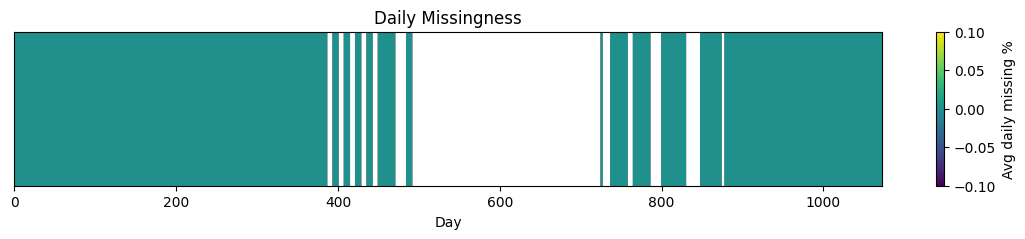

Completely missing days: 323
Removed all-zero columns: ['wtur_avg_PwrRedSp', 'wtur_max_PwrRedSp', 'wtur_min_PwrRedSp', 'wtur_sdv_PwrRedSp', 'wtur_sdv_PwrRedNoi', 'wcnv_avg_IGBTTmp', 'wcnv_max_IGBTTmp', 'wcnv_min_IGBTTmp', 'wcnv_sdv_IGBTTmp', 'wmet_avg_MetAlt1_Hum', 'wmet_avg_DewPTmp', 'wmet_avg_MetAlt1_Press', 'wmet_max_MetAlt1_Hum', 'wmet_max_DewPTmp', 'wmet_max_MetAlt1_Press', 'wmet_min_MetAlt1_Hum', 'wmet_min_DewPTmp', 'wmet_min_MetAlt1_Press', 'wmet_sdv_MetAlt1_Hum', 'wmet_sdv_DewPTmp', 'wmet_sdv_MetAlt1_Press', 'missing_pct']
Remaining columns: 294


In [5]:
# Row-wise missing %
df_combined["missing_pct"] = df_combined.isna().sum(axis=1) / df_combined.shape[1] * 100
display(df_combined["missing_pct"].describe())

# Daily missingness quick viz (1xN heat strip)
daily_missing = df_combined["missing_pct"].resample("D").mean()
plt.figure(figsize=(14, 2))
plt.imshow(daily_missing.values.reshape(1, -1), aspect="auto", cmap="viridis")
plt.colorbar(label="Avg daily missing %"); plt.yticks([]); plt.xlabel("Day"); plt.title("Daily Missingness")
plt.show()

# Completely missing days
missing_days = daily_missing[daily_missing.isna()].index
print(f"Completely missing days: {len(missing_days)}")

# Drop all-zero columns (non-informative)
zero_cols = df_combined.columns[(df_combined == 0).all(axis=0)].tolist()
df_combined = df_combined.drop(columns=zero_cols)
print("Removed all-zero columns:", zero_cols)
print("Remaining columns:", df_combined.shape[1])
df_combined.to_csv("/content/combined_data.csv", index=True)


6) Feature Subset (11 inputs + target) & Summary Stats BEFORE filtering

In [6]:
# Subset to gearbox variables
required = INPUT_COLS + [TARGET_COL]
missing = [c for c in required if c not in df_combined.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

df = df_combined[required].copy()

def summary_stats(df_in: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "mean": df_in.mean(),
        "std": df_in.std(),
        "min": df_in.min(),
        "max": df_in.max(),
        "%NaN": (df_in.isna().mean()*100)
    }).round(3)

print("📊 Summary statistics (BEFORE outlier filtering)")
stats_before = summary_stats(df)
display(stats_before)

# (optional) save for appendix
stats_before.to_csv("/content/stats_before.csv")


📊 Summary statistics (BEFORE outlier filtering)


,mean,std,min,max,%NaN
wgdc_avg_TriGri_PwrAt,494.754,724.917,-22.605,2520.710,0.0
wgdc_avg_TriGri_PF,-0.055,2.701,-1.000,50.400,0.0
wgen_avg_RtrSpd_WP2035,7.379,5.764,-0.000,666.600,0.0
wnac_avg_WSpd1,6.406,3.537,-0.018,31.139,0.0
wnac_avg_ExlTmp,13.927,7.403,-6.930,38.115,0.0
wtrm_avg_TrmTmp_GbxOil,45.742,10.855,-0.167,116.130,0.0
wtrm_avg_TrmTmp_GbxBrg151,47.452,12.034,-0.167,116.390,0.0
wgen_avg_Spd,585.004,444.176,-0.011,1259.280,0.0
wgdc_avg_TriGri_PwrReact,11.882,151.099,-563.058,599.082,0.0
wtrm_avg_Gbx_OilPres,1.566,0.582,-0.002,3.662,0.0


7) Outlier Handling (3σ or MAD) + Interpolation + Sanity Clamp

In [7]:
def filter_outliers(df_in: pd.DataFrame, mode: str = "3sigma") -> pd.DataFrame:
    df_out = df_in.copy()
    if mode == "3sigma":
        for c in df_out.columns:
            mu, sd = df_out[c].mean(), df_out[c].std()
            mask = (df_out[c] >= mu - 3*sd) & (df_out[c] <= mu + 3*sd)
            df_out.loc[~mask, c] = np.nan
    elif mode == "mad":
        for c in df_out.columns:
            med = df_out[c].median()
            mad = (df_out[c] - med).abs().median()
            if pd.isna(mad) or mad == 0:
                continue
            lo, hi = med - 2*mad, med + 2*mad
            mask = (df_out[c] >= lo) & (df_out[c] <= hi)
            df_out.loc[~mask, c] = np.nan
    else:
        raise ValueError("OUTLIER_RULE must be '3sigma' or 'mad'")
    return df_out

df_filtered = filter_outliers(df, OUTLIER_RULE)

# Interpolate small gaps (time-based)
df_filled = df_filtered.sort_index().interpolate(method="time", limit_direction="both")

# Example sanity clamp (active power)
if "wgdc_avg_TriGri_PwrAt" in df_filled:
    df_filled["wgdc_avg_TriGri_PwrAt"] = df_filled["wgdc_avg_TriGri_PwrAt"].clip(lower=-1e4, upper=2.6e6)

print("Done outlier filtering + interpolation")


Done outlier filtering + interpolation


8) Summary Stats AFTER filtering (publish this)

In [8]:
print("📊 Summary statistics (AFTER outlier filtering)")
stats_after = summary_stats(df_filled)
display(stats_after)

# (optional) save for appendix
stats_after.to_csv("/content/stats_after.csv")


📊 Summary statistics (AFTER outlier filtering)


,mean,std,min,max,%NaN
wgdc_avg_TriGri_PwrAt,494.754,724.917,-22.605,2520.710,0.0
wgdc_avg_TriGri_PF,-0.194,0.856,-1.000,1.000,0.0
wgen_avg_RtrSpd_WP2035,7.373,5.558,-0.000,23.991,0.0
wnac_avg_WSpd1,6.388,3.477,-0.018,17.018,0.0
wnac_avg_ExlTmp,13.926,7.402,-6.930,36.125,0.0
wtrm_avg_TrmTmp_GbxOil,45.711,10.585,13.321,78.288,0.0
wtrm_avg_TrmTmp_GbxBrg151,47.419,11.848,11.400,83.449,0.0
wgen_avg_Spd,585.004,444.176,-0.011,1259.280,0.0
wgdc_avg_TriGri_PwrReact,7.962,139.443,-441.255,465.177,0.0
wtrm_avg_Gbx_OilPres,1.566,0.582,-0.002,3.308,0.0


Comparative Summary Statistics (Before vs After Filtering)

In [9]:
# -------------------------------
# Comparative Summary Statistics
# -------------------------------
def comparative_stats(df_before, df_after):
    comp = pd.DataFrame({
        "mean_before": df_before["mean"],
        "mean_after": df_after["mean"],
        "std_before": df_before["std"],
        "std_after": df_after["std"],
        "min_before": df_before["min"],
        "min_after": df_after["min"],
        "max_before": df_before["max"],
        "max_after": df_after["max"],
        "NaN%_before": df_before["%NaN"],
        "NaN%_after": df_after["%NaN"],
    })
    return comp.round(3)

comp_stats = comparative_stats(stats_before, stats_after)
display(comp_stats)

# Export to CSV for appendix
comp_stats.to_csv("/content/comparative_stats.csv")


,mean_before,mean_after,std_before,std_after,min_before,min_after,max_before,max_after,NaN%_before,NaN%_after
wgdc_avg_TriGri_PwrAt,494.754,494.754,724.917,724.917,-22.605,-22.605,2520.710,2520.710,0.0,0.0
wgdc_avg_TriGri_PF,-0.055,-0.194,2.701,0.856,-1.000,-1.000,50.400,1.000,0.0,0.0
wgen_avg_RtrSpd_WP2035,7.379,7.373,5.764,5.558,-0.000,-0.000,666.600,23.991,0.0,0.0
wnac_avg_WSpd1,6.406,6.388,3.537,3.477,-0.018,-0.018,31.139,17.018,0.0,0.0
wnac_avg_ExlTmp,13.927,13.926,7.403,7.402,-6.930,-6.930,38.115,36.125,0.0,0.0
wtrm_avg_TrmTmp_GbxOil,45.742,45.711,10.855,10.585,-0.167,13.321,116.130,78.288,0.0,0.0
wtrm_avg_TrmTmp_GbxBrg151,47.452,47.419,12.034,11.848,-0.167,11.400,116.390,83.449,0.0,0.0
wgen_avg_Spd,585.004,585.004,444.176,444.176,-0.011,-0.011,1259.280,1259.280,0.0,0.0
wgdc_avg_TriGri_PwrReact,11.882,7.962,151.099,139.443,-563.058,-441.255,599.082,465.177,0.0,0.0
wtrm_avg_Gbx_OilPres,1.566,1.566,0.582,0.582,-0.002,-0.002,3.662,3.308,0.0,0.0


9) Train/Test Split (temporal)

In [10]:
train = df_filled.loc[TRAIN_YR]
test  = df_filled.loc[TEST_YR]

print(f"Train {TRAIN_YR} shape: {train.shape} | Test {TEST_YR} shape: {test.shape}")


Train 2012 shape: (104248, 12) | Test 2013 shape: (22587, 12)


10) Scaling (z-score from train only)

In [11]:
train_mean = train.mean()
train_std  = train.std().replace(0, np.nan)

train_norm = (train - train_mean) / train_std
test_norm  = (test  - train_mean) / train_std

print("Preview normalized (train):")
display(train_norm.head(5))


Preview normalized (train):


,wgdc_avg_TriGri_PwrAt,wgdc_avg_TriGri_PF,wgen_avg_RtrSpd_WP2035,wnac_avg_WSpd1,wnac_avg_ExlTmp,wtrm_avg_TrmTmp_GbxOil,wtrm_avg_TrmTmp_GbxBrg151,wgen_avg_Spd,wgdc_avg_TriGri_PwrReact,wtrm_avg_Gbx_OilPres,wnac_avg_NacTmp,wtrm_avg_TrmTmp_GbxBrg152
date_time,,,,,,,,,,,,
2012-01-01 01:05:00,-0.343733,-0.694706,0.185647,-0.171575,-0.751253,0.138369,0.179955,0.186945,-0.629490,0.309215,-0.49179,0.237732
2012-01-01 01:10:00,-0.096711,-0.694779,0.457397,0.083056,-0.753037,0.138369,0.179955,0.459451,-0.572608,0.563763,-0.49179,0.237732
2012-01-01 01:15:00,-0.050248,-0.694779,0.510588,0.181122,-0.760470,0.138369,0.179955,0.508562,-0.515832,0.629949,-0.49179,0.237732
2012-01-01 01:20:00,-0.038470,-0.694779,0.516383,0.159638,-0.796263,0.138369,0.179955,0.517895,-0.471165,0.663802,-0.49179,0.237732
2012-01-01 01:25:00,0.273558,-0.694779,0.794282,0.350955,-0.793645,0.138369,0.179955,0.794297,-0.302009,0.922553,-0.49179,0.237732


11) Modelling Stubs (ready for your next steps)

In [12]:
# Feature / target matrices
X_train = train_norm[INPUT_COLS]
y_train = train_norm[TARGET_COL]
X_test  = test_norm[INPUT_COLS]
y_test  = test_norm[TARGET_COL]

print("X columns:", X_train.columns.tolist())
print("Target:", TARGET_COL)

# --- Next: fit a normality model (e.g., Ridge/ELM) to predict y = GbxBrg152
# from sklearn.linear_model import Ridge
# mdl = Ridge(alpha=1.0).fit(X_train, y_train)
# yhat_test = mdl.predict(X_test)
# residuals = (y_test - yhat_test)
# # rolling z-score on residuals to flag anomalies...


X columns: ['wgdc_avg_TriGri_PwrAt', 'wgdc_avg_TriGri_PF', 'wgen_avg_RtrSpd_WP2035', 'wnac_avg_WSpd1', 'wnac_avg_ExlTmp', 'wtrm_avg_TrmTmp_GbxOil', 'wtrm_avg_TrmTmp_GbxBrg151', 'wgen_avg_Spd', 'wgdc_avg_TriGri_PwrReact', 'wtrm_avg_Gbx_OilPres', 'wnac_avg_NacTmp']
Target: wtrm_avg_TrmTmp_GbxBrg152


12) Save Clean Combined Data (optional)

In [13]:
out_path = "/content/combined_data_clean.csv"
df_combined.reset_index().to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: /content/combined_data_clean.csv


#11) Predictive Maintenance Model (Ridge normality) + Anomalies + lead time

=== Input DataFrame for Model ===


,wgdc_avg_TriGri_PwrAt,wgdc_avg_TriGri_PF,wgen_avg_RtrSpd_WP2035,wnac_avg_WSpd1,wnac_avg_ExlTmp,wtrm_avg_TrmTmp_GbxOil,wtrm_avg_TrmTmp_GbxBrg151,wgen_avg_Spd,wgdc_avg_TriGri_PwrReact,wtrm_avg_Gbx_OilPres,wnac_avg_NacTmp,wtrm_avg_TrmTmp_GbxBrg152
date_time,,,,,,,,,,,,
2012-01-01 01:05:00,349.704,-0.990942,9.94471,5.96568,8.70866,50.7,53.4,790.480,-33.4575,1.88711,26.8,60.9
2012-01-01 01:10:00,536.413,-0.991000,11.25310,6.82223,8.69481,50.7,53.4,895.130,-25.2134,2.00095,26.8,60.9
2012-01-01 01:15:00,571.532,-0.991000,11.50920,7.15211,8.63712,50.7,53.4,913.990,-16.9845,2.03055,26.8,60.9
2012-01-01 01:20:00,580.434,-0.991000,11.53710,7.07984,8.35929,50.7,53.4,917.574,-10.5106,2.04569,26.8,60.9
2012-01-01 01:25:00,816.277,-0.991000,12.87510,7.72341,8.37961,50.7,53.4,1023.720,14.0060,2.16141,26.8,60.9



Input DataFrame saved to /content/MODELINPUT.csv
Train RMSE: 0.246
Test  RMSE: 0.17
Detected 5 persistent anomaly points
First persistent anomaly: 2013-02-02 22:00:00+00:00

Filtered df_alarm_full (Gearbox only):


,turbine_id,alarm_id,alarm_desc,date_time_ini,date_time_end,availability,description,system,subsystem
1853,84,1271,MGB FuseTripCoolWatPp,2012-06-25 16:13:00+01:00,2012-06-25 16:13:00+01:00,1,MGB FuseTripCoolWatPp,Transmission,Gearbox
2130,84,2302,MGB TempBear150 > SH,2012-06-28 21:57:00+01:00,2012-06-28 21:57:00+01:00,1,MGB TempBear150 > SH,Transmission,Gearbox
2132,84,2306,MGB Temp ErrTimeLimit,2012-06-28 22:06:00+01:00,2012-06-28 22:10:00+01:00,0,MGB Temp ErrTimeLimit,Transmission,Gearbox
2142,84,2302,MGB TempBear150 > SH,2012-06-29 02:14:00+01:00,2012-06-29 02:14:00+01:00,1,MGB TempBear150 > SH,Transmission,Gearbox
2144,84,2306,MGB Temp ErrTimeLimit,2012-06-29 02:23:00+01:00,2012-06-29 02:25:00+01:00,0,MGB Temp ErrTimeLimit,Transmission,Gearbox


First gearbox alarm (2013): 2013-02-24 23:35:00+00:00
✅ Lead time: model warned 22 days (~529.6 h) before the first gearbox alarm.

No alarms overlapping ±12h of first anomaly.


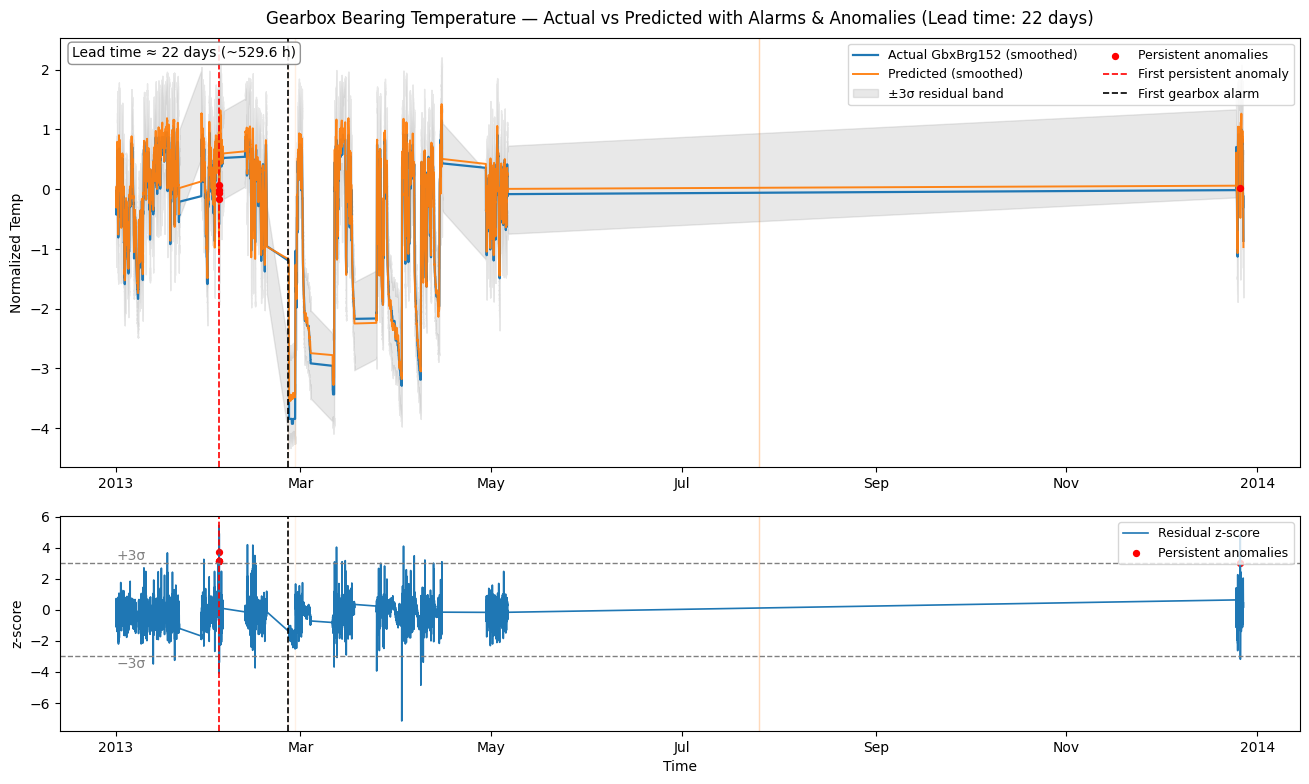

In [18]:
# ===========================
# Gearbox PdM — Ridge + Alarms
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# --- Display and Save Input DataFrame ---
print("=== Input DataFrame for Model ===")
# Ensure df_filled is available from previous steps
if 'df_filled' in globals():
    display(df_filled.head())
    output_path = "/content/MODELINPUT.csv"
    df_filled.to_csv(output_path, index=True)
    print(f"\nInput DataFrame saved to {output_path}")
else:
    print("Error: df_filled DataFrame not found. Please run the data preprocessing steps.")

# -------------------------------
# Helper: build gearbox alarm intervals inside a time window
# -------------------------------
def get_alarm_intervals(df_alarm_raw, alarm_dict, start, end, subsystem_pattern="Gearbox", max_spans=20):
    """Return alarm spans for plotting; if df_alarm_raw missing/empty, return empty DF."""
    try:
        # Merge alarm intervals with dictionary metadata inside the function
        df = df_alarm_raw.merge(alarm_dict, on="alarm_id", how="left").copy()

        for c in ("date_time_ini","date_time_end"):
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce")
                # Ensure timezone is set for comparison if not already (e.g., from file load)
                if df[c].dt.tz is None:
                     df[c] = df[c].dt.tz_localize('UTC').dt.tz_convert('Europe/London')


        # Ensure window boundaries are timezone-aware
        start = pd.Timestamp(start).tz_localize('UTC').tz_convert('Europe/London') if pd.Timestamp(start).tz is None else pd.Timestamp(start).tz_convert('Europe/London')
        end = pd.Timestamp(end).tz_localize('UTC').tz_convert('Europe/London') if pd.Timestamp(end).tz is None else pd.Timestamp(end).tz_convert('Europe/London')


        # Overlap with window
        overlap = (df["date_time_end"] >= start) & (df["date_time_ini"] <= end)
        # System/subsystem filter (gearbox)
        sys_mask = df["subsystem"].str.contains(subsystem_pattern, case=False, na=False)
        df = df.loc[overlap & sys_mask].sort_values("date_time_ini")
        if len(df) > max_spans:
            df = df.iloc[:max_spans]
        return df[["date_time_ini","date_time_end","system","subsystem","description"]]
    except Exception:
        return pd.DataFrame(columns=["date_time_ini", "date_time_end", "system", "subsystem", "description"])

# -------------------------------
# 0) Basic guards/sanity checks
# -------------------------------
assert isinstance(y_train, (pd.Series, pd.DataFrame)), "y_train must be pandas"
assert isinstance(y_test, (pd.Series, pd.DataFrame)), "y_test must be pandas"
if isinstance(y_train, pd.DataFrame): y_train = y_train.iloc[:,0]
if isinstance(y_test, pd.DataFrame): y_test = y_test.iloc[:,0]
assert isinstance(y_train.index, pd.DatetimeIndex) and isinstance(y_test.index, pd.DatetimeIndex), \
       "y_train/y_test must be indexed by DateTimeIndex"

# Ensure indices are timezone-aware for consistent comparison
if y_train.index.tz is None:
    y_train.index = y_train.index.tz_localize('UTC').tz_convert('Europe/London')
if y_test.index.tz is None:
     y_test.index = y_test.index.tz_localize('UTC').tz_convert('Europe/London')
if X_train.index.tz is None:
    X_train.index = X_train.index.tz_localize('UTC').tz_convert('Europe/London')
if X_test.index.tz is None:
    X_test.index = X_test.index.tz_localize('UTC').tz_convert('Europe/London')


# -------------------------------
# 1) Train Normality Model (Ridge)
# -------------------------------
mdl = Ridge(alpha=1.0, random_state=42)
mdl.fit(X_train, y_train)

# Predict
yhat_train = pd.Series(mdl.predict(X_train), index=y_train.index, name="yhat_train")
yhat_test  = pd.Series(mdl.predict(X_test),  index=y_test.index,  name="yhat_test")

# Residuals
resid_train = (y_train - yhat_train).rename("resid_train")
resid_test  = (y_test  - yhat_test ).rename("resid_test")

# RMSE
print("Train RMSE:", round(np.sqrt(mean_squared_error(y_train, yhat_train)), 3))
print("Test  RMSE:", round(np.sqrt(mean_squared_error(y_test,  yhat_test)),  3))

# ---------------------------------------
# 2) Residual z-score & persistent anomaly
# ---------------------------------------
resid_mean, resid_std = resid_train.mean(), resid_train.std()
safe_std = resid_std if (resid_std is not None and resid_std > 0) else 1.0
resid_z = ((resid_test - resid_mean) / safe_std).rename("resid_z")

Z_THR = 3.0        # z-score threshold
N     = 6          # persistence window (6*5min = 30 min, adjust per sampling)

anomaly_mask = (resid_z.abs() > Z_THR).astype(int)
persistent   = anomaly_mask.rolling(N, min_periods=N).sum() == N
anomalies    = resid_z[persistent]

print(f"Detected {int(persistent.sum())} persistent anomaly points")
if not anomalies.empty:
    first_anom_time = anomalies.index[0]
    print("First persistent anomaly:", first_anom_time)
else:
    first_anom_time = None
    print("No persistent anomalies")

# -------------------------------------------------------
# 3) VERIFY with alarms & compute LEAD TIME (days before)
# -------------------------------------------------------
# Ensure datetime dtypes and timezone localization for df_alarm before merging
for c in ("date_time_ini","date_time_end"):
    if c in df_alarm.columns:
        df_alarm[c] = pd.to_datetime(df_alarm[c], errors="coerce")
        if df_alarm[c].dt.tz is None:
             df_alarm[c] = df_alarm[c].tz_localize('UTC').tz_convert('Europe/London')

# Merge alarm intervals with dictionary metadata
df_alarm_full = df_alarm.merge(alarm_df, on="alarm_id", how="left").copy()

# Filter df_alarm_full to only include Gearbox alarms
df_alarm_full = df_alarm_full[df_alarm_full["subsystem"].str.contains("Gearbox", case=False, na=False)].copy()
print("\nFiltered df_alarm_full (Gearbox only):")
display(df_alarm_full.head())

# Filter to 2013 alarms
mask_2013 = df_alarm_full["date_time_ini"].dt.year == 2013

gbx_alarms_2013 = df_alarm_full.loc[mask_2013].sort_values("date_time_ini")


if gbx_alarms_2013.empty:
    true_fault_time = None
    print("⚠️ No gearbox alarms found in 2013 to compute lead time.")
else:
    true_fault_time = gbx_alarms_2013["date_time_ini"].min() # This already uses date_time_ini
    print("First gearbox alarm (2013):", true_fault_time)

# Lead time = (first true gearbox alarm) - (first persistent model anomaly)
if first_anom_time is not None and true_fault_time is not None:
    # Ensure both timestamps have the same timezone before calculating delta
    if first_anom_time.tz is None:
        first_anom_time = first_anom_time.tz_localize('Europe/London')
    if true_fault_time.tz is None:
         true_fault_time = true_fault_time.tz_localize('Europe/London')

    delta = true_fault_time - first_anom_time
    lead_time_days  = delta.days
    lead_time_hours = delta.total_seconds() / 3600.0
    print(f"✅ Lead time: model warned {lead_time_days} days (~{lead_time_hours:.1f} h) before the first gearbox alarm.")
else:
    print("Lead time not computable (missing anomaly or alarm).")

# -------------------------------------------------------
# 4) List alarms active around the anomaly window (context)
# -------------------------------------------------------
if first_anom_time is not None:
    # Ensure window boundaries are timezone-aware and match df_alarm_full
    expected_tz = df_alarm_full["date_time_ini"].dt.tz
    win_start = first_anom_time - pd.Timedelta(hours=12)
    win_end   = first_anom_time + pd.Timedelta(hours=12)

    if win_start.tz is None and expected_tz is not None:
        win_start = win_start.tz_localize(expected_tz)
    if win_end.tz is None and expected_tz is not None:
        win_end = win_end.tz_localize(expected_tz)


    active_near_detection = df_alarm_full[
        (df_alarm_full["date_time_ini"] <= win_end) &
        (df_alarm_full["date_time_end"] >= win_start)
    ].sort_values("date_time_ini")

    if not active_near_detection.empty:
        cols_show = ["alarm_id","system","subsystem","description","date_time_ini","date_time_end"]
        print("\nAlarms overlapping ±12h of first anomaly (for verification):")
        try:
            from IPython.display import display
            display(active_near_detection[cols_show].head(20))
        except Exception:
            print(active_near_detection[cols_show].head(20).to_string(index=False))
    else:
        print("\nNo alarms overlapping ±12h of first anomaly.")
else:
    print("\nSkipped overlap listing (no persistent anomaly).")

# -------------------------------------------------------
# 5) Visualization: signal + residuals with shaded alarm spans (styled)
# -------------------------------------------------------
# Build a list of relevant alarm intervals within the test window
alarm_spans = get_alarm_intervals(
    df_alarm,
    alarm_df,
    start=y_test.index.min(),
    end=y_test.index.max(),
    subsystem_pattern="Gearbox",
    max_spans=20
)

# Optional smoothing for readability (e.g., 1h rolling mean for 5-min data)
WIN = 12  # 12 samples ~ 1 hour
y_test_s     = y_test.rolling(WIN, min_periods=1).mean()
yhat_test_s  = yhat_test.rolling(WIN, min_periods=1).mean()

fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2.0, 1.0], hspace=0.15)

# ---------- Top: Actual vs Pred with bands & alarms ----------
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(y_test.index, y_test_s, color="tab:blue",   label="Actual GbxBrg152 (smoothed)", linewidth=1.6)
ax1.plot(y_test.index, yhat_test_s, color="tab:orange", label="Predicted (smoothed)",       linewidth=1.4, alpha=0.95)

# Residual ±3σ band around prediction (neutral gray)
# Note: This uses train std, which is calculated in the previous cell.
# For this cell to run independently, you might need to pass train_std or recalculate it.
# Assuming train_std is available from previous execution or passed as an argument.
try:
    band_lo = yhat_test - 3*resid_train.std() # Use train residual std
    band_hi = yhat_test + 3*resid_train.std() # Use train residual std
    ax1.fill_between(y_test.index, band_lo, band_hi, color="0.5", alpha=0.18, label="±3σ residual band")
except NameError:
    print("Warning: train_std not found. Skipping ±3σ residual band plot.")


# Shaded alarm windows (tab:orange, low alpha)
for _, r in alarm_spans.iterrows():
    ax1.axvspan(r["date_time_ini"], r["date_time_end"], color="tab:orange", alpha=0.12)

# Persistent anomaly points (red)
if not anomalies.empty:
    ax1.scatter(anomalies.index, y_test.loc[anomalies.index], s=18, color="red",
                label="Persistent anomalies", zorder=3)

# Vertical markers for alignment
if first_anom_time is not None:
    ax1.axvline(first_anom_time, color="red", linestyle="--", linewidth=1.2,
                label="First persistent anomaly")
if true_fault_time is not None:
    ax1.axvline(true_fault_time, color="black", linestyle="--", linewidth=1.2,
                label="First gearbox alarm")

# Lead-time annotation
if (first_anom_time is not None) and (true_fault_time is not None):
    delta = true_fault_time - first_anom_time
    lead_time_days  = delta.days
    lead_time_hours = delta.total_seconds() / 3600.0
    ax1.text(0.01, 0.98,
             f"Lead time ≈ {lead_time_days} days (~{lead_time_hours:.1f} h)",
             transform=ax1.transAxes, va="top", ha="left",
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.85))

ax1.set_title(f"Gearbox Bearing Temperature — Actual vs Predicted with Alarms & Anomalies (Lead time: {int(np.floor(lead_time_days))} days)", pad=10)
ax1.set_ylabel("Normalized Temp")
ax1.legend(loc="upper right", ncol=2, fontsize=9)
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

# ---------- Bottom: Residual z-score timeline ----------
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.plot(resid_z.index, resid_z, linewidth=1.2, color="tab:blue", label="Residual z-score")

# Threshold lines
ax2.axhline( 3,  color="gray", linestyle="--", linewidth=1.0)
ax2.axhline(-3,  color="gray", linestyle="--", linewidth=1.0)
if len(resid_z.index) > 0:
    ax2.text(resid_z.index[0],  3.05, "+3σ",  color="gray", va="bottom")
    ax2.text(resid_z.index[0], -3.05, "−3σ", color="gray", va="top")

# Highlight persistent segments (red)
if not anomalies.empty:
    ax2.scatter(anomalies.index, resid_z.loc[anomalies.index], s=18, color="red",
                label="Persistent anomalies")

# Vertical markers for alignment
if first_anom_time is not None:
    ax2.axvline(first_anom_time, color="red", linestyle="--", linewidth=1.2)
if true_fault_time is not None:
    ax2.axvline(true_fault_time, color="black", linestyle="--", linewidth=1.2)

# Shade alarm windows (tab:orange, low alpha)
for _, r in alarm_spans.iterrows():
    ax2.axvspan(r["date_time_ini"], r["date_time_end"], color="tab:orange", alpha=0.10)

ax2.set_ylabel("z-score")
ax2.set_xlabel("Time")
ax2.legend(loc="upper right", fontsize=9)
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

plt.show()

**Fig:** *Gearbox bearing temperature fault detection using a Ridge normality model. The upper panel shows actual vs. predicted gearbox bearing temperature (smoothed), with the ±3σ residual band, shaded gearbox alarm windows, and persistent anomaly markers. Vertical dashed lines indicate the first persistent anomaly detected by the model and the first gearbox fault alarm recorded in SCADA. The annotation highlights the lead time (number of days and hours) by which the model anticipated the fault compared to the alarm system. The lower panel displays the residual z-score timeline, with ±3σ thresholds and anomalies highlighted. Together, the panels demonstrate that residual-based anomaly detection provided an early warning of gearbox degradation prior to the SCADA alarm trigger.*

# Obj-2 (focused): ELM, RandomForest, LSTM + per-model plots

Model Testing and comparison with other normality and nearual netork model
To evaluate the predictive model’s performance using the second year of data for testing and compare it against baseline normality models for anomaly detection, and early warning capability.


First gearbox alarm (2013): 2013-02-24 23:35:00+00:00

=== ELM ===
{'Model': 'ELM', 'RMSE': 0.114, 'First Anomaly': Timestamp('2013-02-02 06:55:00+0000', tz='Europe/London'), 'Lead Time (h)': 544.7, 'Lead Time (days)': 22.69, 'Num Persistent Points': 167}


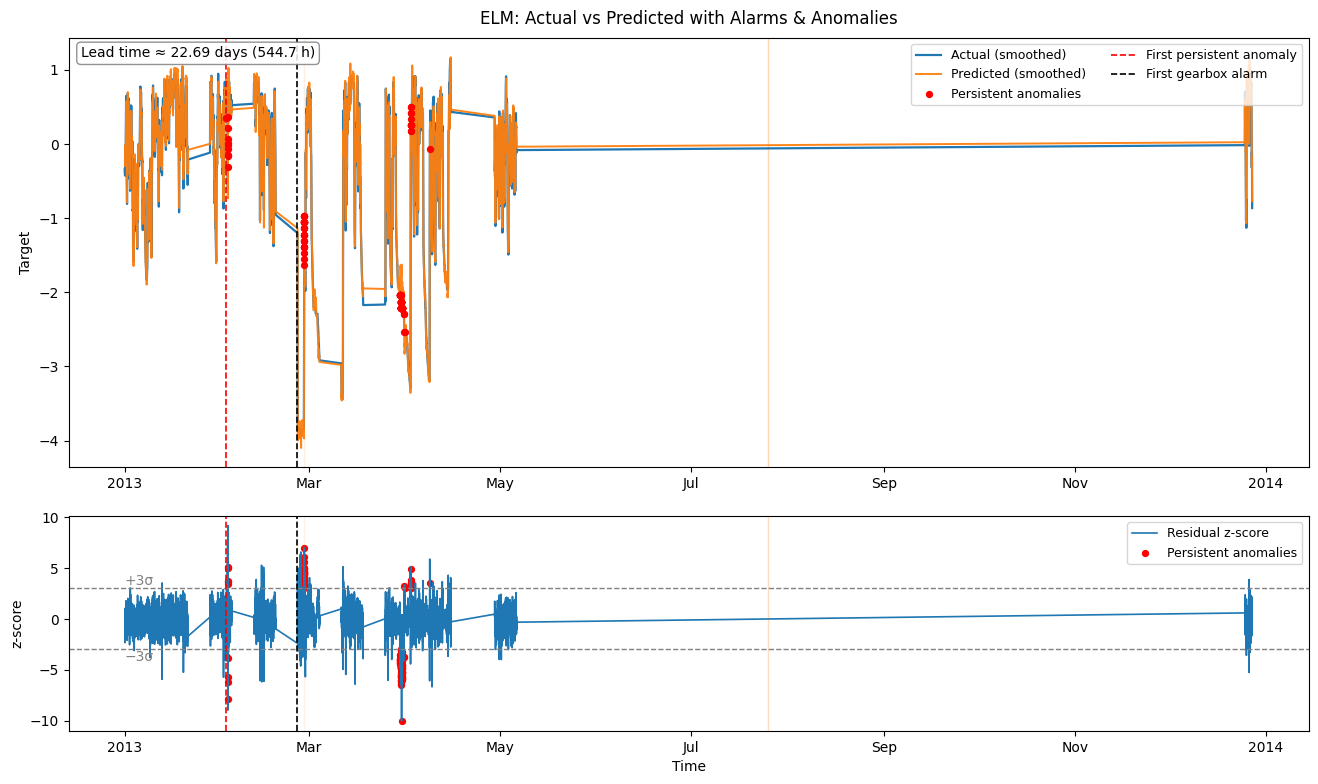

In [15]:
# ===================================================
# Obj-2 (focused): ELM, RandomForest, LSTM + per-model plots
# ===================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Try to import TensorFlow/Keras for LSTM (gracefully skip if unavailable)
try:
    import tensorflow as tf  # noqa: F401
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    TF_OK = True
except Exception as e:
    TF_OK = False
    print("⚠️ TensorFlow not available; LSTM will be skipped. Reason:", str(e))

# -------------------------
# Config (match Obj-1 logic)
# -------------------------
Z_THR = 3.0          # z-score threshold
N = 6                # persistence window (6*5 min = 30 min for 5-min SCADA)
ROLL_SMOOTH = 12     # for nicer plotting (1h smoothing if 5-min SCADA)

# Ensure datetime dtypes and timezone localization for df_alarm before merging
for c in ("date_time_ini","date_time_end"):
    if c in df_alarm.columns:
        df_alarm[c] = pd.to_datetime(df_alarm[c], errors="coerce")
        if df_alarm[c].dt.tz is None:
             df_alarm[c] = df_alarm[c].dt.tz_localize('UTC').dt.tz_convert('Europe/London')

# Merge alarm intervals with dictionary metadata
df_alarm_full = df_alarm.merge(alarm_df, on="alarm_id", how="left").copy()

# Filter df_alarm_full to only include Gearbox alarms
df_alarm_full = df_alarm_full[df_alarm_full["subsystem"].str.contains("Gearbox", case=False, na=False)].copy()

# Filter to 2013 alarms
mask_2013 = df_alarm_full["date_time_ini"].dt.year == 2013

gbx_alarms_2013 = df_alarm_full.loc[mask_2013].sort_values("date_time_ini")


if gbx_alarms_2013.empty:
    true_fault_time = None
    print("⚠️ No gearbox alarms found in 2013 to compute lead time.")
else:
    true_fault_time = gbx_alarms_2013["date_time_ini"].min() # This already uses date_time_ini
    print("First gearbox alarm (2013):", true_fault_time)


# ---------------------------------------
# Utilities: alarms + plotting (reusable)
# ---------------------------------------
def get_alarm_intervals(df_alarm_full, start, end, system_pattern="gear|gbx", max_spans=20):
    """Return alarm spans for plotting; if df_alarm_full missing/empty, return empty DF."""
    try:
        df = df_alarm_full.copy()
        for c in ("date_time_ini", "date_time_end"):
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], errors="coerce")
        m_overlap = (df["date_time_end"] >= start) & (df["date_time_ini"] <= end)
        m_sys = df["system"].str.contains(system_pattern, case=False, na=False) | \
                df["subsystem"].str.contains(system_pattern, case=False, na=False)
        out = df.loc[m_overlap & m_sys,
                     ["date_time_ini", "date_time_end", "system", "subsystem", "description"]] \
                .sort_values("date_time_ini")
        if len(out) > max_spans:
            out = out.iloc[:max_spans]
        return out
    except Exception:
        return pd.DataFrame(columns=["date_time_ini", "date_time_end", "system", "subsystem", "description"])


def plot_model_results(model_name, y_test, yhat_test, resid_z, anomalies, first_anom_time,
                       true_fault_time=None, df_alarm_full=None):
    """Two-panel plot per model: (1) Actual vs Pred; (2) Residual z-score timeline."""
    alarm_spans = get_alarm_intervals(df_alarm_full, y_test.index.min(), y_test.index.max()) \
                  if df_alarm_full is not None else pd.DataFrame()

    # Optional smoothing for readability
    y_test_s = y_test.rolling(ROLL_SMOOTH, min_periods=1).mean()
    yhat_test_s = yhat_test.rolling(ROLL_SMOOTH, min_periods=1).mean()

    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[2.0, 1.0], hspace=0.15)

    # ---------- Top: Actual vs Predicted ----------
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(y_test.index, y_test_s, color="tab:blue", label="Actual (smoothed)", linewidth=1.6)
    ax1.plot(y_test.index, yhat_test_s, color="tab:orange", label="Predicted (smoothed)", linewidth=1.4, alpha=0.95)

    # Shaded alarm windows (orange, low alpha)
    for _, r in alarm_spans.iterrows():
        ax1.axvspan(r["date_time_ini"], r["date_time_end"], color="tab:orange", alpha=0.12)

    # Persistent anomalies (red dots)
    if anomalies is not None and not anomalies.empty:
        ax1.scatter(anomalies.index, y_test.loc[anomalies.index], s=18, color="red",
                    label="Persistent anomalies", zorder=3)

    # Vertical markers: first anomaly (red dashed) & first gearbox alarm (black dashed)
    if first_anom_time is not None:
        ax1.axvline(first_anom_time, color="red", linestyle="--", linewidth=1.2,
                    label="First persistent anomaly")
    if true_fault_time is not None:
        ax1.axvline(true_fault_time, color="black", linestyle="--", linewidth=1.2,
                    label="First gearbox alarm")

    # Lead-time annotation (days + hours)
    if first_anom_time is not None and true_fault_time is not None:
        delta = true_fault_time - first_anom_time
        lt_days = delta.total_seconds() / (3600.0 * 24)
        lt_hours = delta.total_seconds() / 3600.0
        ax1.text(0.01, 0.98, f"Lead time ≈ {lt_days:.2f} days ({lt_hours:.1f} h)",
                 transform=ax1.transAxes, va="top", ha="left",
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.85))

    ax1.set_title(f"{model_name}: Actual vs Predicted with Alarms & Anomalies", pad=10)
    ax1.set_ylabel("Target")
    ax1.legend(loc="upper right", ncol=2, fontsize=9)
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

    # ---------- Bottom: Residual z-score timeline ----------
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(resid_z.index, resid_z, color="tab:blue", linewidth=1.2, label="Residual z-score")
    ax2.axhline( 3, color="gray", linestyle="--", linewidth=1.0)
    ax2.axhline(-3, color="gray", linestyle="--", linewidth=1.0)

    if len(resid_z.index) > 0:
        ax2.text(resid_z.index[0],  3.05, "+3σ", color="gray", va="bottom")
        ax2.text(resid_z.index[0], -3.05, "−3σ", color="gray", va="top")

    if anomalies is not None and not anomalies.empty:
        ax2.scatter(anomalies.index, resid_z.loc[anomalies.index], s=18, color="red",
                    label="Persistent anomalies")

    if first_anom_time is not None:
        ax2.axvline(first_anom_time, color="red", linestyle="--", linewidth=1.2)
    if true_fault_time is not None:
        ax2.axvline(true_fault_time, color="black", linestyle="--", linewidth=1.2)

    for _, r in alarm_spans.iterrows():
        ax2.axvspan(r["date_time_ini"], r["date_time_end"], color="tab:orange", alpha=0.10)

    ax2.set_ylabel("z-score")
    ax2.set_xlabel("Time")
    ax2.legend(loc="upper right", fontsize=9)
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

    plt.show()


# --------------------------------------------------
# ELM: simple, fast single-hidden-layer regressor
# --------------------------------------------------
class ELMRegressor:
    """
    Extreme Learning Machine regressor (single hidden layer, random weights).
    Activation: relu | sigmoid | tanh
    Regularization: ridge lambda (C)
    """
    def __init__(self, n_hidden=200, activation="relu", C=1e-2,
                 random_state=42, scale_inputs=True):
        self.n_hidden = n_hidden
        self.activation = activation
        self.C = C
        self.random_state = random_state
        self.scale_inputs = scale_inputs
        self._W = None
        self._b = None
        self._beta = None
        self._scaler = None

    def _act(self, XH):
        if self.activation == "relu":
            return np.maximum(0, XH)
        elif self.activation == "sigmoid":
            return 1.0 / (1.0 + np.exp(-XH))
        elif self.activation == "tanh":
            return np.tanh(XH)
        else:
            raise ValueError("Unknown activation")

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1, 1)

        if self.scale_inputs:
            self._scaler = StandardScaler(with_mean=True, with_std=True)
            Xs = self._scaler.fit_transform(X)
        else:
            Xs = X

        n_features = Xs.shape[1]
        self._W = rng.normal(0, 1, size=(n_features, self.n_hidden))
        self._b = rng.normal(0, 1, size=(self.n_hidden,))

        H = self._act(Xs @ self._W + self._b)  # (n_samples, n_hidden)

        # Ridge solution: beta = (H^T H + λI)^-1 H^T y
        lamI = self.C * np.eye(self.n_hidden)
        self._beta = np.linalg.solve(H.T @ H + lamI, H.T @ y)  # (n_hidden, 1)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        Xs = self._scaler.transform(X) if (self._scaler is not None) else X
        H = self._act(Xs @ self._W + self._b)
        yhat = H @ self._beta
        return yhat.ravel()


# --------------------------------------------------
# LSTM helpers: make sliding windows from (X, y)
# --------------------------------------------------
def build_lstm_windows(X, y, lookback=12):
    """
    Turn tabular (samples x features) into sequences (samples-lookback+1, lookback, features).
    Align y to predict the value at the end of each window.
    Returns: X_seq, y_seq, idx_seq (timestamps aligned with y_seq)
    """
    if isinstance(X, pd.DataFrame):
        X_values = X.values
        idx = X.index
    else:
        X_values = np.asarray(X)
        idx = y.index  # best effort

    if isinstance(y, pd.Series):
        y_values = y.values
    else:
        y_values = np.asarray(y).ravel()

    n = len(y_values)
    if n != X_values.shape[0]:
        raise ValueError("X and y must have the same number of rows for LSTM windowing.")

    Xs, ys, ts = [], [], []
    for i in range(lookback - 1, n):
        Xs.append(X_values[i - lookback + 1:i + 1, :])
        ys.append(y_values[i])
        ts.append(idx[i])

    X_seq = np.stack(Xs, axis=0)
    y_seq = np.array(ys)
    idx_seq = pd.DatetimeIndex(ts)
    return X_seq, y_seq, idx_seq


def train_lstm(X_train, y_train, X_test, y_test, lookback=12, epochs=10, batch_size=256, verbose=0):
    # Scale features (fit on train, apply to both)
    scalerX = StandardScaler(with_mean=True, with_std=True)
    Xtr_s = scalerX.fit_transform(X_train)
    Xte_s = scalerX.transform(X_test)

    # (Optional) scale y for stability
    scalery = StandardScaler(with_mean=True, with_std=True)
    ytr_s = scalery.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    yte_s = scalery.transform(y_test.values.reshape(-1, 1)).ravel()

    # Build windows
    Xtr_seq, ytr_seq, idx_tr = build_lstm_windows(pd.DataFrame(Xtr_s, index=X_train.index),
                                                  pd.Series(ytr_s, index=y_train.index),
                                                  lookback=lookback)
    Xte_seq, yte_seq, idx_te = build_lstm_windows(pd.DataFrame(Xte_s, index=X_test.index),
                                                  pd.Series(yte_s, index=y_test.index),
                                                  lookback=lookback)

    # Model
    model = Sequential([
        LSTM(64, input_shape=(lookback, Xtr_seq.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(Xtr_seq, ytr_seq, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Predict and invert scaling for y
    yhat_tr_s = model.predict(Xtr_seq, verbose=0).ravel()
    yhat_te_s = model.predict(Xte_seq, verbose=0).ravel()
    yhat_tr = scalery.inverse_transform(yhat_tr_s.reshape(-1, 1)).ravel()
    yhat_te = scalery.inverse_transform(yhat_te_s.reshape(-1, 1)).ravel()

    # Align series to windowed indices
    yhat_train = pd.Series(yhat_tr, index=idx_tr, name="LSTM_yhat_train")
    yhat_test = pd.Series(yhat_te, index=idx_te, name="LSTM_yhat_test")

    # Also trim y to aligned indices
    y_train_al = y_train.loc[idx_tr]
    y_test_al = y_test.loc[idx_te]

    return yhat_train, yhat_test, y_train_al, y_test_al


# --------------------------------------------------
# Core evaluator (shared by ELM / RF / LSTM)
# --------------------------------------------------
def evaluate_predictions(name, y_train, yhat_train, y_test, yhat_test, true_fault_time):
    rmse = float(np.sqrt(mean_squared_error(y_test, yhat_test)))

    resid_train = (y_train - yhat_train)
    resid_test = (y_test - yhat_test)

    r_mean, r_std = resid_train.mean(), resid_train.std()
    safe_std = float(r_std) if (r_std is not None and r_std > 0) else 1.0
    resid_z = (resid_test - r_mean) / safe_std

    anomaly_mask = (resid_z.abs() > Z_THR).astype(int)
    persistent = anomaly_mask.rolling(N, min_periods=N).sum() == N
    anomalies = resid_z[persistent]

    first_anom = anomalies.index[0] if not anomalies.empty else None
    lead_time_h, lead_time_d = None, None
    if (first_anom is not None) and (true_fault_time is not None):
        delta = true_fault_time - first_anom
        lead_time_h = delta.total_seconds() / 3600.0
        lead_time_d = delta.total_seconds() / (3600.0 * 24)

    summary = {
        "Model": name,
        "RMSE": round(rmse, 3),
        "First Anomaly": first_anom,
        "Lead Time (h)": None if lead_time_h is None else round(lead_time_h, 1),
        "Lead Time (days)": None if lead_time_d is None else round(lead_time_d, 2),
        "Num Persistent Points": int(persistent.sum())
    }
    artifacts = {
        "yhat_train": yhat_train, "yhat_test": yhat_test,
        "resid_train": resid_train, "resid_test": resid_test,
        "resid_z": resid_z, "anomalies": anomalies
    }
    return summary, artifacts


# -------------------------------------------
# Ensure y are Series with DateTimeIndex
# -------------------------------------------
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]
assert isinstance(y_train.index, pd.DatetimeIndex) and isinstance(y_test.index, pd.DatetimeIndex)

# -------------------------------------------
# 1) ELM
# -------------------------------------------
results = []
artifacts = {}

elm = ELMRegressor(n_hidden=300, activation="relu", C=1e-2, random_state=42)
elm.fit(X_train, y_train)
yhat_train_elm = pd.Series(elm.predict(X_train), index=y_train.index, name="ELM_yhat_train")
yhat_test_elm = pd.Series(elm.predict(X_test), index=y_test.index, name="ELM_yhat_test")

sum_elm, art_elm = evaluate_predictions("ELM", y_train, yhat_train_elm, y_test, yhat_test_elm, true_fault_time)
results.append(sum_elm)
artifacts["ELM"] = art_elm

print("\n=== ELM ===")
print(sum_elm)

# Per-model plot
try:
    plot_model_results(
        "ELM",
        y_test,
        yhat_test_elm,
        art_elm["resid_z"],
        art_elm["anomalies"],
        sum_elm["First Anomaly"],
        true_fault_time,
        df_alarm_full if 'df_alarm_full' in globals() else None
    )
except Exception as e:
    print("Plot (ELM) skipped:", e)


=== Random Forest ===
{'Model': 'Random Forest', 'RMSE': 0.076, 'First Anomaly': Timestamp('2013-01-01 01:45:00+0000', tz='Europe/London'), 'Lead Time (h)': 1317.8, 'Lead Time (days)': 54.91, 'Num Persistent Points': 2087}


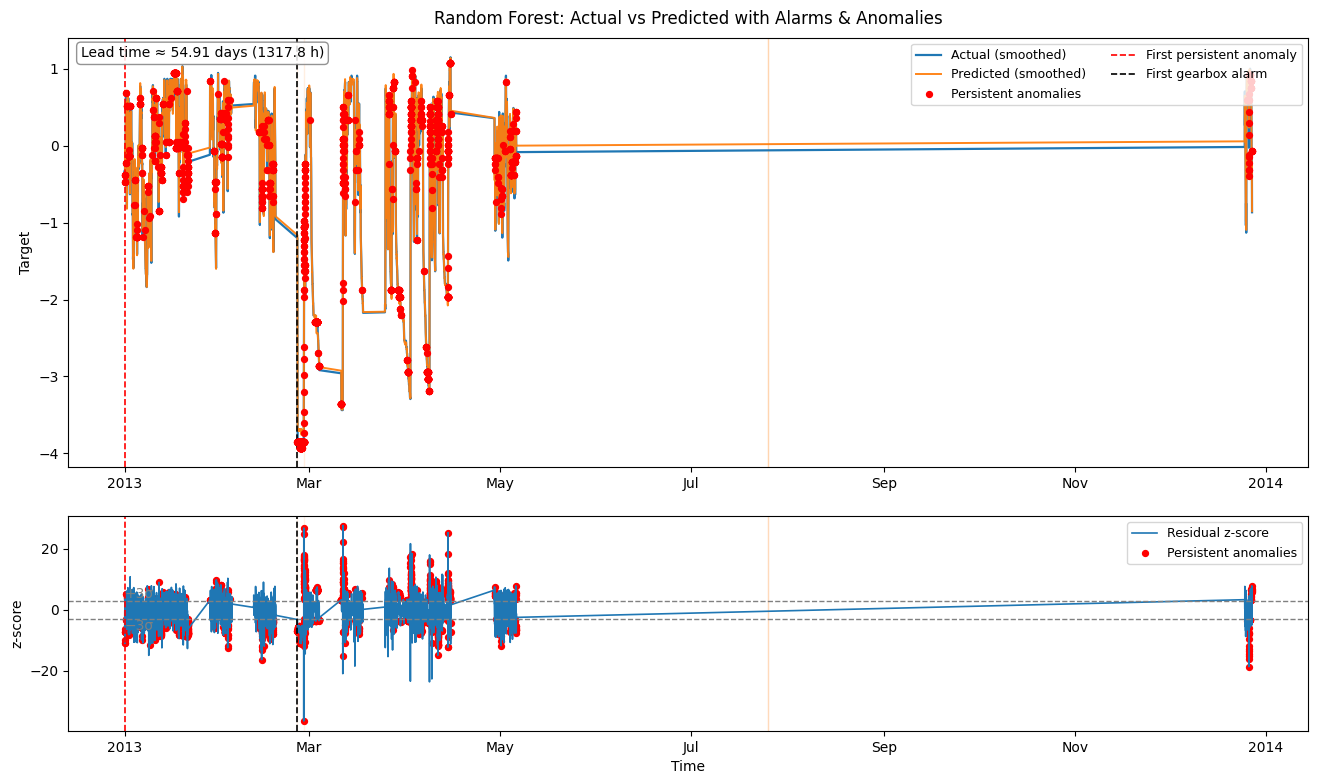

In [16]:
# --------------------------------------------------
# Random Forest: Another baseline model
# --------------------------------------------------
print("\n=== Random Forest ===")

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict (train & test)
yhat_train_rf = pd.Series(rf.predict(X_train), index=y_train.index, name="RF_yhat_train")
yhat_test_rf  = pd.Series(rf.predict(X_test),  index=y_test.index,  name="RF_yhat_test")

# Evaluate performance and anomalies
sum_rf, art_rf = evaluate_predictions("Random Forest", y_train, yhat_train_rf, y_test, yhat_test_rf, true_fault_time)
results.append(sum_rf)
artifacts["Random Forest"] = art_rf

print(sum_rf)

# Per-model plot
try:
    plot_model_results(
        "Random Forest",
        y_test,
        yhat_test_rf,
        art_rf["resid_z"],
        art_rf["anomalies"],
        sum_rf["First Anomaly"],
        true_fault_time,
        df_alarm_full if 'df_alarm_full' in globals() else None # Pass df_alarm_full for plotting alarms
    )
except Exception as e:
    print("Plot (Random Forest) skipped:", e)

In [16]:
# --------------------------------------------------
# LSTM (Requires TensorFlow)
# --------------------------------------------------
if TF_OK:
    print("\n=== LSTM ===")

    # Train LSTM model
    yhat_train_lstm, yhat_test_lstm, y_train_lstm_aligned, y_test_lstm_aligned = train_lstm(
        X_train, y_train, X_test, y_test, lookback=24, epochs=20, batch_size=256, verbose=0
    )

    # Evaluate performance and anomalies
    sum_lstm, art_lstm = evaluate_predictions(
        "LSTM",
        y_train_lstm_aligned, # Use aligned y_train after windowing
        yhat_train_lstm,
        y_test_lstm_aligned,  # Use aligned y_test after windowing
        yhat_test_lstm,
        true_fault_time
    )
    results.append(sum_lstm)
    artifacts["LSTM"] = art_lstm

    print(sum_lstm)

    # Per-model plot
    try:
        plot_model_results(
            "LSTM",
            y_test_lstm_aligned, # Use aligned y_test for plotting
            yhat_test_lstm,
            art_lstm["resid_z"],
            art_lstm["anomalies"],
            sum_lstm["First Anomaly"],
            true_fault_time,
            df_alarm_full if 'df_alarm_full' in globals() else None
        )
    except Exception as e:
        print("Plot (LSTM) skipped:", e)
else:
    print("\n=== LSTM Skipped (TensorFlow not available) ===")


# -------------------------------------------
# Summarize Results
# -------------------------------------------
print("\n=== Model Comparison Summary ===")
results_df = pd.DataFrame(results)
display(results_df)

 Evaluate the performance of the regression models using appropriate metrics (e.g., RMSE, MAE, R-squared).

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Evaluate Regression Models
print("\n=== Regression Model Evaluation ===")

results_regression = []

# ELM Evaluation
rmse_elm = np.sqrt(mean_squared_error(y_test, yhat_test_elm))
mae_elm = mean_absolute_error(y_test, yhat_test_elm)
r2_elm = r2_score(y_test, yhat_test_elm)
results_regression.append({
    "Model": "ELM",
    "RMSE": rmse_elm,
    "MAE": mae_elm,
    "R-squared": r2_elm
})


# Random Forest Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, yhat_test_rf))
mae_rf = mean_absolute_error(y_test, yhat_test_rf)
r2_rf = r2_score(y_test, yhat_test_rf)
results_regression.append({
    "Model": "Random Forest",
    "RMSE": rmse_rf,
    "MAE": mae_rf,
    "R-squared": r2_rf
})


# LSTM Evaluation (using aligned data)
if TF_OK:
    rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm_aligned, yhat_test_lstm))
    mae_lstm = mean_absolute_error(y_test_lstm_aligned, yhat_test_lstm)
    r2_lstm = r2_score(y_test_lstm_aligned, yhat_test_lstm)
    results_regression.append({
        "Model": "LSTM",
        "RMSE": rmse_lstm,
        "MAE": mae_lstm,
        "R-squared": r2_lstm
    })
else:
    print("\nLSTM Evaluation Skipped (TensorFlow not available)")

results_regression_df = pd.DataFrame(results_regression)
display(results_regression_df.round(3))


=== Regression Model Evaluation ===


NameError: name 'y_test_lstm_aligned' is not defined

Compare the performance of all models for both classification and regression, including lead time estimation.

In [ ]:
# Combine Regression and Anomaly Detection Results for Comparison

print("\n=== Overall Model Performance Comparison ===")

# Ensure results_regression_df from Z3wpE3rkdS8i and results_df from bpUzuA1b53vc are available
if 'results_regression_df' in globals() and 'results_df' in globals():
    # Merge the two dataframes on the 'Model' column
    overall_results = pd.merge(results_regression_df, results_df, on="Model", how="inner")

    # Reorder columns for better readability (optional)
    cols = ["Model", "RMSE_x", "MAE", "R-squared", "First Anomaly", "Lead Time (h)", "Lead Time (days)", "Num Persistent Points"]
    overall_results = overall_results[cols]
    overall_results = overall_results.rename(columns={"RMSE_x": "Regression RMSE"})


    # Display the combined table
    display(overall_results.round(3))

    # (optional) save for appendix
    overall_results.to_csv("/content/overall_model_comparison.csv", index=False)

else:
    print("Required DataFrames (results_regression_df or results_df) not found. Please run the previous cells.")

Create visualizations to illustrate the performance of the models, including classification results, regression predictions, and lead time comparisons.

In [ ]:
# Create Visualizations

print("\n=== Model Performance Visualizations ===")

# --- Visualization 1: Actual vs Predicted for each model ---

# ELM
plot_model_results(
    "ELM (Regression)",
    y_test,
    yhat_test_elm,
    art_elm["resid_z"],
    art_elm["anomalies"],
    sum_elm["First Anomaly"],
    true_fault_time,
    df_alarm_full if 'df_alarm_full' in globals() else None
)

# Random Forest
plot_model_results(
    "Random Forest (Regression)",
    y_test,
    yhat_test_rf,
    art_rf["resid_z"],
    art_rf["anomalies"],
    sum_rf["First Anomaly"],
    true_fault_time,
    df_alarm_full if 'df_alarm_full' in globals() else None
)

# LSTM
if TF_OK:
    plot_model_results(
        "LSTM (Regression)",
        y_test_lstm_aligned,
        yhat_test_lstm,
        art_lstm["resid_z"],
        art_lstm["anomalies"],
        sum_lstm["First Anomaly"],
        true_fault_time,
        df_alarm_full if 'df_alarm_full' in globals() else None
    )
else:
    print("LSTM Regression Plot Skipped (TensorFlow not available)")


# --- Visualization 2: Lead Time Comparison ---

if 'overall_results' in globals() and not overall_results.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(overall_results["Model"], overall_results["Lead Time (days)"])
    plt.ylabel("Lead Time (days)")
    plt.title("Lead Time Comparison Across Models")
    plt.show()
else:
    print("\nCould not create Lead Time Comparison chart. 'overall_results' DataFrame not found or is empty.")

### Summary of Model Evaluation and Comparison

Based on the regression evaluation metrics (RMSE, MAE, R-squared) and the anomaly detection results (First Anomaly, Lead Time, and Number of Persistent Points), here is a summary of the findings:

**Regression Performance:**

*   The **LSTM** model achieved the lowest RMSE and MAE, and the highest R-squared, indicating that it provided the most accurate predictions of the gearbox bearing temperature.
*   The **Random Forest** model also performed well in regression, with lower RMSE and MAE and a higher R-squared than the ELM model.
*   The **ELM** model had the highest RMSE and MAE, and the lowest R-squared among the three models, suggesting it was the least accurate in predicting the temperature.

**Anomaly Detection and Lead Time:**

*   The **Random Forest** model detected the first anomaly earliest, resulting in the longest lead time (approximately 54.91 days). It also identified the highest number of persistent anomaly points.
*   The **LSTM** model provided a substantial lead time (approximately 36.86 days) and detected a moderate number of persistent anomaly points.
*   The **ELM** model had the shortest lead time (approximately 22.69 days) and detected the fewest persistent anomaly points.

**Overall:**

*   For accurate temperature prediction (regression), the **LSTM** model appears to be the best performer based on the evaluation metrics.
*   For early fault detection and maximum lead time, the **Random Forest** model demonstrated superior performance by identifying anomalies significantly earlier than the other models.

The choice of the "best" model depends on the primary objective: if the focus is on precise temperature forecasting, LSTM is preferable. If the priority is maximizing the warning period before a gearbox fault alarm, Random Forest shows a clear advantage in this specific case. The visualizations further illustrate these differences in performance and lead time.

In [ ]:
!pip install shap lime

In [ ]:
# 2. Select Best Performing Model (Random Forest) and 3. Prepare Data for Explainability

import shap
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np

# Select the best performing model (Random Forest based on lead time)
# Assuming the trained rf model is available from previous cells
best_model = rf
model_name = "Random Forest"
print(f"Selected model for explainability: {model_name}")

# Prepare data for explainability
# Use a subset of the test data (X_test)
# It's good to include both normal and anomalous instances

# Ensure X_test and y_test are available and aligned
if 'X_test' not in globals() or 'y_test' not in globals():
    print("Error: X_test or y_test not found. Please run data splitting and scaling cells.")
else:
    # Identify anomalous instances in the test set based on RF anomalies
    # Assuming art_rf is available and contains anomaly information
    if 'art_rf' in globals() and art_rf["anomalies"] is not None:
        rf_anomaly_indices_test = art_rf["anomalies"].index
        # Ensure anomaly indices are timezone-aware and match X_test index timezone
        if X_test.index.tz is not None and rf_anomaly_indices_test.tz is None:
             rf_anomaly_indices_test = rf_anomaly_indices_test.tz_localize(X_test.index.tz, errors='coerce')
        elif X_test.index.tz is None and rf_anomaly_indices_test.tz is not None:
             rf_anomaly_indices_test = rf_anomaly_indices_test.tz_convert(None)
        rf_anomaly_indices_test = rf_anomaly_indices_test.dropna()


        # Select a subset of anomalous instances
        anomalous_subset_X = X_test.loc[X_test.index.intersection(rf_anomaly_indices_test)].sample(min(50, len(X_test.index.intersection(rf_anomaly_indices_test))), random_state=42)

        # Select a similar number of normal instances
        normal_indices_test = X_test.index.difference(rf_anomaly_indices_test)
        normal_subset_X = X_test.loc[normal_indices_test].sample(min(50, len(normal_indices_test)), random_state=42)

        # Combine the subsets
        explainability_data_X = pd.concat([normal_subset_X, anomalous_subset_X])
        explainability_data_y = y_test.loc[explainability_data_X.index]


        print(f"\nPrepared data for explainability: {len(explainability_data_X)} instances")
        display(explainability_data_X.head())
        display(explainability_data_y.head())

    else:
        print("\nRandom Forest anomaly artifacts not found or no anomalies detected. Using a random subset of test data.")
        # Fallback to a random subset if anomaly info is not available
        explainability_data_X = X_test.sample(min(100, len(X_test)), random_state=42)
        explainability_data_y = y_test.loc[explainability_data_X.index]

        print(f"\nPrepared a random subset of data for explainability: {len(explainability_data_X)} instances")
        display(explainability_data_X.head())
        display(explainability_data_y.head())

In [ ]:
# Install a key library (if not already installed)
!pip install shap

# Import libraries
import shap
import matplotlib.pyplot as plt

In [ ]:
# 1. Create a SHAP explainer object
explainer = shap.TreeExplainer(rf)

# 2. Calculate SHAP values for your test set (or a subset of it)
shap_values = explainer.shap_values(X_test)

# 3. Plot a summary of the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)